In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/MyDrive/NLP/Assignment1'

2BENS_Assignment1_v2.ipynb  Logs    ZEBS_Assignment1.ipynb
BENS_Assignment1.ipynb	    Model1


In [ ]:
# WORKING IN GOOGLE COLAB
! python3 -m pip install transformers datasets evaluate scikit-learn tqdm
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,\
    TrainingArguments, Trainer, pipeline, DataCollatorWithPadding, set_seed
import evaluate
import numpy as np
import torch.nn as nn
import math
import time
from tqdm import tqdm

In [50]:
set_seed(42)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [51]:
# 0 is ENTAILMENT
# 1 is NEUTRAL
# 2 is CONTRADICTION
snli = load_dataset("snli")
snli

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [52]:
snli_removed_minus_one = snli.filter(lambda example: example["label"] != -1)
snli_removed_minus_one

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9824
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 549367
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9842
    })
})

In [53]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
tokenizer = distilbert_tokenizer

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file to

In [54]:
#BLOCK FROM CHATGPT

train_dataset = snli_removed_minus_one["train"].map(lambda example: tokenizer(example["premise"], example["hypothesis"], padding=True, return_tensors="pt"), batched=True)
val_dataset = snli_removed_minus_one["validation"].map(lambda example: tokenizer(example["premise"], example["hypothesis"], padding=True, return_tensors="pt"), batched=True)
test_dataset = snli_removed_minus_one["test"].map(lambda example: tokenizer(example["premise"], example["hypothesis"], padding=True, return_tensors='pt'), batched=True)

  0%|          | 0/550 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [55]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [56]:
accuracy = evaluate.load("accuracy")

In [57]:
# def preprocess_function(examples):
#     return tokenizer(examples["text"], truncation=True)
    
# tokenized_snli_train= snli_train.map(preprocess_function, batched=True)
# tokenized_snli_test = snli_test.map(preprocess_function, batched=True)
# tokenized_snli_val = snli_val.map(preprocess_function,batched=True)

In [58]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = numpy.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [59]:
# Is this necessary? yes
id2label = {0: "entailment", 1: "neutral", 2:"contradiction"}
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522

In [60]:
train_loss_list = []
train_acc_list = []
eval_loss_list = []
eval_acc_list = []
time_per_epoch_list = []

In [61]:
class CustomTrainer(Trainer):
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        train_loss=[]
        train_acc=[]
        eval_acc=[]

        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):

            print("starting epoch")
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):

                    # print(f'the step is {step}')
                    # print(f'the inputs are {inputs}')
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # print(f'the labels are {labels}')

                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'])
                    # print(f'the output is {output}')

                    # get the loss
                    loss = criterion(output['logits'], labels)
                    train_loss_per_epoch += loss.item()
                    # print(f'the loss is {loss}')
                    # print(f'the new train loss per epoch is {train_loss_per_epoch}')

                    #calculate gradients
                    loss.backward()

                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            
            
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    with torch.no_grad():
                        output = model(inputs['input_ids'])
                        loss = criterion(output['logits'], labels)
                        eval_loss_per_epoch += loss.item()
                        eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
        
            
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')
            train_loss_list.append(train_loss_per_epoch)
            train_acc_list.append(train_acc_per_epoch)
            eval_loss_list.append(eval_loss_per_epoch)
            eval_acc_list.append(eval_acc_per_epoch)
            time_per_epoch_list.append((time.time()-start)/60)
    
        print(f'Time: {(time.time()-start)/60:.3f} minutes')

In [64]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/Assignment1",
    learning_rate=1e-7,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [65]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [66]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: hypothesis, premise. If hypothesis, premise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: hypothesis, premise. If hypothesis, premise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


starting epoch


Training Epoch 0:   5%|▍         | 824/17168 [01:53<37:26,  7.27batch/s]


KeyboardInterrupt: ignored

In [27]:
model.save_pretrained("/content/drive/MyDrive/NLP/Assignment1")

Configuration saved in /content/drive/MyDrive/NLP/Assignment1/config.json
Model weights saved in /content/drive/MyDrive/NLP/Assignment1/pytorch_model.bin


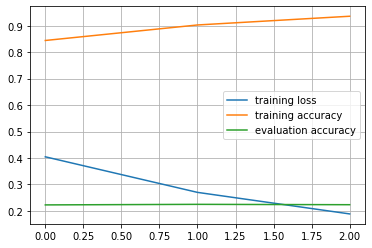

In [28]:
import matplotlib.pyplot as plt

# Data for plotting
t = np.arange(0.0, 100, 1)

# fig, ax = plt.subplots()
plt.plot(train_loss_list, label="training loss")
plt.plot(train_acc_list, label="training accuracy")
# plt.plot(eval_loss_list, label="evaluation loss")
plt.plot(eval_acc_list, label="evaluation accuracy")
plt.legend()
# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')
plt.grid()

# fig.savefig("test.png")
plt.show()

In [44]:
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP/Assignment1/Model4")

loading configuration file /content/drive/MyDrive/NLP/Assignment1/Model3/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/NLP/Assignment1/Model3",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weig

In [45]:
bert_based_uncased_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522

In [49]:
# 0 is ENTAILMENT
# 1 is NEUTRAL
# 2 is CONTRADICTION


nlp_base = pipeline("sentiment-analysis", model=bert_based_uncased_model, tokenizer=tokenizer, device=device)

nlp_tuned = pipeline("sentiment-analysis", model=fine_tuned_model, tokenizer=tokenizer, device=device)

total_num = 0

correct_base = 0

correct_tuned = 0
correct_roberta = 0

for i in range(len(snli_removed_minus_one["test"])):
  total_num += 1

  premise = snli_removed_minus_one["test"][i]["premise"]
  hypothesis = snli_removed_minus_one["test"][i]["hypothesis"]

  text = premise + " " + hypothesis
  result_base = nlp_base(text)[0]
  result_tuned = nlp_tuned(text)[0]

  # result_roberta = nlp_roberta(text)[0]
  # print("prediction: ", result_roberta)
  # print(result_roberta["label"])

  if(snli_removed_minus_one["test"][i]["label"] == label2id[result_base["label"]]):
    correct_base += 1

  if(snli_removed_minus_one["test"][i]["label"] == label2id[result_tuned["label"]]):
    correct_tuned += 1


print("Base accuracy: ", correct_base/total_num)
print("Tune accuracy: ", correct_tuned/total_num)

Base accuracy:  0.3296009771986971
Tune accuracy:  0.8903705211726385
